# Install and import libraries

In [ ]:
pip install h5py typing-extensions wheel

In [ ]:
pip install diffrax equinox jax optax sklearn scipy dtaidistance fastdtw

In [ ]:
pip install git+https://github.com/justagist/pylasadataset

  Cloning https://github.com/justagist/pylasadataset to /tmp/pip-req-build-orzjslwn
  Running command git clone --filter=blob:none --quiet https://github.com/justagist/pylasadataset /tmp/pip-req-build-orzjslwn
  Resolved https://github.com/justagist/pylasadataset to commit fad83aa7049f1680114505c3f19abf0c4a2cccc8
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate
import numpy as np

# Load dataset and preprocess

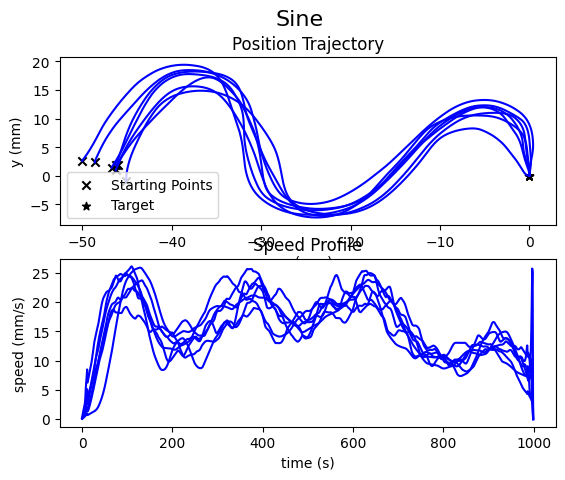

In [ ]:
import pyLasaDataset as lasa

# DataSet object has all the LASA handwriting data files
# as attributes, eg:
angle_data = lasa.DataSet.Angle
sine_data = lasa.DataSet.Sine
Leaf_2_data = lasa.DataSet.Leaf_2
CShape_data = lasa.DataSet.CShape
DoubleBendedLine = lasa.DataSet.DoubleBendedLine

data = lasa.DataSet.Sine


# Each Data object has attributes dt and demos (For documentation,
# refer original dataset repo:
# https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt)
dt = data.dt
demos = data.demos # list of 7 Demo objects, each corresponding to a
                         # repetition of the pattern


# Each Demo object in demos list will have attributes pos, t, vel, acc
# corresponding to the original .mat format described in
# https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt
demo_0 = demos[1]
pos = demo_0.pos # np.ndarray, shape: (2,2000)
vel = demo_0.vel # np.ndarray, shape: (2,2000)
acc = demo_0.acc # np.ndarray, shape: (2,2000)
t = demo_0.t # np.ndarray, shape: (1,2000)


# To visualise the data (2D position and velocity) use the plot_model utility
lasa.utilities.plot_model(data) # give any of the available
                                                   # pattern data as argument

# Define models

In [ ]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    @eqx.filter_jit
    def __call__(self, t, y, args):

        return self.mlp(y)

In [ ]:
class Funcd(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=2*data_size,
            out_size=2*data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    @eqx.filter_jit
    def __call__(self, t, yd, args):

        return self.mlp(yd)
        # return self.mlp(jnp.concatenate([yd, jnp.array([t])]))

In [ ]:
class NeuralODE(eqx.Module):
    func: Func
    metric: Metric

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)
        self.metric = Metric(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [ ]:
class NeuralODEd(eqx.Module):
    func: Funcd

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Funcd(data_size, width_size, depth, key=key)

    @eqx.filter_jit
    def __call__(self, ts, yd0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=yd0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

# Process data. batch_size $\neq$ dataset_size

In [ ]:
ndemos = len(demos)
T = demos[0].t.shape[-1]
pos_all = []
vel_all = []
for i in range(ndemos):
  pos_all.append((demos[i].pos).T)
  vel_all.append((demos[i].vel).T)
posn = jnp.array(pos_all)
veln = jnp.array(vel_all)
tn =  jnp.array(t.T).reshape(T)
ys_all_n = jnp.concatenate((posn,veln),axis=2)

In [ ]:
nsamples = 1000
ts = t[0]/t[0, -1]
ts_new = jnp.linspace(0, 1, nsamples)

dim = posn.shape[2]

traj_process = jnp.zeros((ndemos, nsamples, dim))
vel_process = jnp.zeros((ndemos, nsamples, dim))

traj_all_t_norm = []
# time_all_process = jnp.zeros((traj_c, nsamples))

seed = 1385

key = jax.random.PRNGKey(seed)
scale_state = 1

key_trajs = jax.random.split(key, num=ndemos)

for i in range(ndemos):
  key_dim = jax.random.split(key_trajs[i], num=dim)
  for j in range(dim):
    f = interpolate.interp1d(ts, posn[i, :, j])
    f_vel = interpolate.interp1d(ts, veln[i, :, j])
    # f = interpolate.interp1d(time_all[i][:, 0], traj_all[i][:, j])
    # ts_new = np.linspace(time_all[i][0, 0], time_all[i][-1, 0], nsamples)
    # time_all_process = time_all_process.at[i].set(ts_new)
    traj_new = f(ts_new)
    vel_new = f_vel(ts_new)
    traj_process = traj_process.at[i, :, j].set(scale_state*traj_new)
    vel_process = vel_process.at[i, :, j].set(scale_state*vel_new)

## Train_Test_split

nTD = 4
traj_train = traj_process[1:nTD]
vel_train = vel_process[1:nTD]

traj_test = traj_process[nTD:]
vel_test = vel_process[nTD:]

## Multi_models

# train_indx = [0, 2, 4, 6]
# nTD = len(train_indx)
# traj_train = jnp.zeros((len(train_indx), nsamples, dim))
# vel_train = jnp.zeros((len(train_indx), nsamples, dim))
# c=0

# for i in train_indx:
#   traj_train = traj_train.at[c].set(traj_process[i])
#   vel_train = vel_train.at[c].set(vel_process[i])
#   c += 1

# test_indx = [1, 3, 5]
# traj_test = jnp.zeros((len(test_indx), nsamples, dim))
# vel_test = jnp.zeros((len(test_indx), nsamples, dim))
# c=0

# for i in test_indx:
#   traj_test = traj_test.at[c].set(traj_process[i])
#   vel_test = vel_test.at[c].set(vel_process[i])
#   c += 1

traj_all_train = jnp.concatenate((traj_train, vel_train), axis=2)
traj_all_test = jnp.concatenate((traj_test, vel_test), axis=2)

# Dataloader

In [ ]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

# Train

In [ ]:
def main(
    dataset_size=nTD,
    batch_size=int(nTD/2),
    lr_strategy=(3e-3,),
    steps_strategy=(3000,),
    length_strategy=(1,),
    width_size=64,
    depth=3,
    seed=1000,
    plot=True,
    print_every=100,
    save_every=500,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    ys = traj_train
    ts = tn
    ys_dot = vel_train
    ys_all = traj_all_train

    # ys = posn[:nTD]
    # ts = tn
    # ys_dot = veln[:nTD]
    # ys_all = ys_all_n[:nTD]

    # file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/LASA_models/CoRL_2023/WShape_checkpoint.eqx"

    # ts, ys, ys_dot = get_data(dataset_size, key=data_key)

    # yst = jnp.copy(ys)

    # scaler = MinMaxScaler()
    # for i in range(dataset_size):
    #   scaler.fit(ys[i])
    #   ysti = scaler.transform(ys[i])
    #   yst = yst.at[i].set(ysti)
    #   # yst = jnp.expand_dims(yst, axis = 0)
    # scaler.fit(ts.reshape(-1,1))
    # tst = scaler.transform(ts.reshape(-1,1))
    # tst = tst.reshape(-1,)

    # ys = yst
    # ts = tst

    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        f = lambda t, z: model.func(t, z, _)
        # y_dot_pred = jax.vmap(jax.vmap(f, in_axes = (0, 0)), in_axes=(None, 0))(ti, yi)
        loss = jnp.mean((yi - y_pred) ** 2)
        # loss = jnp.mean((y_dot_pred - yi_dot)**2)
        return loss

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    time_all = 0

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        decay_scheduler = optax.cosine_decay_schedule(lr, decay_steps=steps, alpha=0.95)
        # decay_scheduler = optax.piecewise_constant_schedule(init_value=lr, boundaries_and_scales={int(steps*0.25):0.5, int(steps*0.5):0.5, int(steps*0.75):0.5})
        # decay_scheduler = optax.exponential_decay(init_value=lr, transition_steps=steps, decay_rate=0.98, transition_begin=int(steps*0.25), staircase=False)
        # decay_scheduler = optax.linear_schedule(init_value=lr, end_value=0.005*lr, transition_steps=steps, transition_begin=int(steps*0.25))
        optim = optax.adabelief(learning_rate=decay_scheduler)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        # _ys_dot = ys_dot[:, : int(length_size * length)]
        _ys_all = ys_all_n[:, :int(length_size * length)]
        ## Single trajectory
        # for step in range(steps):
        #   start = time.time()
        #   loss, model, opt_state = make_step(_ts, _ys, _ys_dot, model, opt_state)
        #   end = time.time()
        #   if (step % print_every) == 0 or step == steps - 1:
        #     print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
        ## Batches
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            time_all += end - start
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
            # if (step % save_every) == 0 or step == steps - 1:
            #   eqx.tree_serialise_leaves(file_name, model)

    # if plot:
    #     plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
    #     plt.plot(ts, ys[0, :, 1], c="dodgerblue")
    #     model_y = model(ts, ys[0, 0])
    #     plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
    #     plt.plot(ts, model_y[:, 1], c="crimson")
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.savefig("neural_ode.png")
    #     plt.show()

    return ts, ys, model, time_all

In [ ]:
ts, ys, model, time_all = main()

# Plot predicted trajectories

In [ ]:
train_indx = 0
plt.plot(posn[train_indx, :, 0], posn[train_indx, :, 1], c="dodgerblue", label="Real")
plt.plot(posn[train_indx, 0, 0], posn[train_indx, 0, 1], c="black", marker='o', markersize = '12', label="Start")
plt.plot(posn[train_indx, -1, 0], posn[train_indx, -1, 1], c="black", marker='x', markersize = '12', label="Target")
model_y = model(2*ts, posn[train_indx, 0])
plt.plot(model_y[:, 0], model_y[:, 1], c="crimson", label="Model")
model_y = model(2*ts, posn[train_indx, 0] + np.array([0, 5]))
plt.plot(model_y[:, 0], model_y[:, 1], c="crimson", label="Model")
model_y = model(2*ts, posn[train_indx, 0] + np.array([5, 0]))
plt.plot(model_y[:, 0], model_y[:, 1], c="crimson", label="Model")
plt.legend()
plt.tight_layout()
plt.savefig("neural_ode.png")
plt.show()

# Save the model

In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/LASA_models/Sine_semi_Metric_checkpoint.eqx"
eqx.tree_serialise_leaves(file_name, model)

# Load the model

In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/LASA_models/CoRL_2023/Sine_checkpoint.eqx"
# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Tunnel_no_d_checkpoint.eqx"
ys = posn
ts = tn
ys_dot = veln
_, length_size, data_size = ys.shape
width_size=128
depth=3
seed=1000
key = jrandom.PRNGKey(seed)
data_key, model_key, loader_key = jrandom.split(key, 3)
model1 = NeuralODE(data_size, width_size, depth, key=model_key)
model_load_1 = eqx.tree_deserialise_leaves(file_name, model1)

# Plot predicted trajectories

In [ ]:
y_pred = jax.vmap(model_load_1, in_axes=(None, 0))(ts, posn[:, 0])

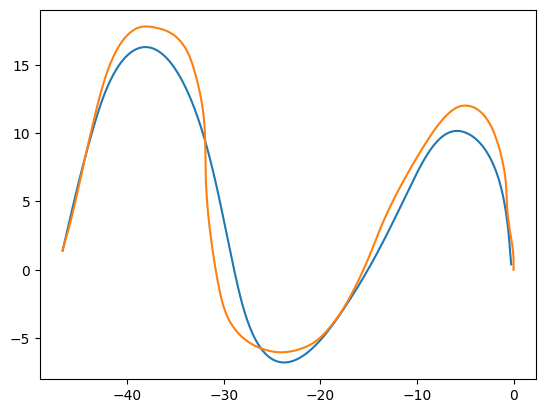

In [ ]:
for i in range(5, 6):
  plt.plot(y_pred[i, :, 0], y_pred[i, :, 1])
  plt.plot(posn[i, :, 0], posn[i, :, 1])